## Adding Libraries, Importing Datasets.

In [2]:
library(tidyverse)
library(nflfastR)
library(ggthemes) # Themes for ggplot2.
library(ggimage) # Supports images in ggplot2.
library(gt) # Create tables.
library(readr) # Read in datasets.
options(scipen = 9999)

In [3]:
# Custom plot settings.
theme_reach <- function() {
  theme_fivethirtyeight() +
    theme(
      legend.position = "none",
      plot.title = element_text(size = 22, hjust = 0.5, face = "bold"),
      plot.subtitle = element_text(size = 18, hjust = 0.5),
      plot.caption = element_text(size = 16),
      axis.title.x = element_text(size=18, margin = margin(t = 20)),
      axis.title.y = element_text(size=18, margin = margin(r = 20)),
      axis.text = element_text(size = 14),
      strip.text = element_text(size = 16, face = "bold"),
      legend.text = element_text(size = 14)
    )
}

In [8]:
ignore <- c("enforced between downs.")
pbp_raw <- load_pbp(2021) %>%
  filter(season == 2021) %>%
  filter(season_type == "REG") %>%
  filter(play_type != "no_play" | str_detect(desc, paste(ignore, collapse = "|"))) %>% 
  filter(!(str_detect(desc, "enforced between downs.") & str_detect(desc, "Kick formation"))) %>%
  filter(!(str_detect(desc, "enforced between downs.") & str_detect(desc, "No Play.")))
pbp_raw$new_play_num <- ave(pbp_raw$play_id ,pbp_raw$game_id,FUN = seq_along)
pbp_raw <- pbp_raw %>%
  mutate(UNIQUE_PLAY_ID = paste(game_id, new_play_num, sep = "_"))

pbp_sportradar <- read_csv(file = "C:/Users/chris/Documents/Datasets/Sportradar NFL/CSV/2021-Sportradar-NFL.csv",
                          show_col_types = FALSE)

## Joining Datasets.

In [9]:
joined_pbp <- inner_join(pbp_raw, pbp_sportradar, by = "UNIQUE_PLAY_ID")

## Adding Columns for Cumulative Rushes/Passes, Run/Pass Share.

In [10]:
joined_pbp <- joined_pbp %>%
  filter(rush == 1 | pass == 1) %>%
  filter(!is.na(epa)) %>%
  mutate(gid_team = paste(game_id, posteam, sep = "-")) %>%
  mutate(yr_team = paste(season, posteam, sep = "-"))

joined_pbp$rushes_game <- ave(joined_pbp$rush, joined_pbp$gid_team, FUN = cumsum)
joined_pbp$passes_game <- ave(joined_pbp$pass, joined_pbp$gid_team, FUN = cumsum)
joined_pbp$rushes_season <- ave(joined_pbp$rush, joined_pbp$yr_team, FUN = cumsum)
joined_pbp$passes_season <- ave(joined_pbp$pass, joined_pbp$yr_team, FUN = cumsum)
joined_pbp$season_play_num <- ave(joined_pbp$play_id, joined_pbp$yr_team, FUN = seq_along)

joined_pbp <- joined_pbp %>%
  mutate(run_share_gm = round(rushes_game/(rushes_game + passes_game), 4)) %>%
  mutate(pass_share_gm = round(passes_game/(rushes_game + passes_game), 4)) %>%
  mutate(run_share_szn = round(rushes_season/(rushes_season + passes_season), 4)) %>%
  mutate(pass_share_szn = round(passes_season/(rushes_season + passes_season), 4))

## Creating Subsets.

In [11]:
sea_pbp <- joined_pbp %>%
  filter(posteam == "SEA") %>%
  filter(week > 4)

nfl_pbp <- joined_pbp %>%
  filter(posteam != "SEA")

russ_pbp_pre <- sea_pbp %>%
  filter(season_play_num < 246)
geno_pbp <- sea_pbp %>%
  filter(season_play_num >= 246) %>%
  filter(season_play_num < 438)
russ_pbp_post <- sea_pbp %>%
  filter(season_play_num >= 438)

## Create and Save 'Russ Effect on Run Rate' Scatterplot.

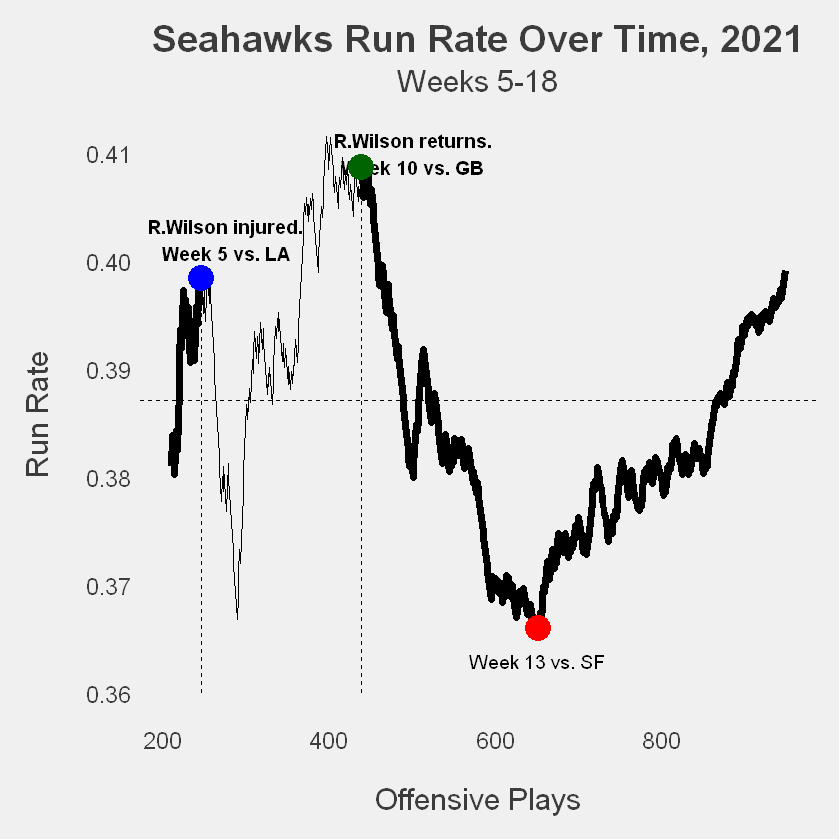

In [12]:
ggplot() +
  geom_line(data = russ_pbp_pre,
            aes(x = season_play_num, y = run_share_szn),
            size = 2) +
  geom_line(data = geno_pbp,
            aes(x = season_play_num, y = run_share_szn),
            size = 0.25) +
  geom_line(data = russ_pbp_post,
            aes(x = season_play_num, y = run_share_szn),
            size = 2) +
  geom_hline(yintercept = sum(nfl_pbp$rush)/nrow(nfl_pbp), linetype = "dashed") +
  geom_segment(aes(x = 246, xend = 246, y = 0.36, yend = 0.3984), linetype = "dashed") +
  geom_segment(aes(x = 438, xend = 438, y = 0.36, yend = 0.4087), linetype = "dashed") +
  theme_reach() +
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank()) +
  labs(x = "Offensive Plays",
       y = "Run Rate",
       title = "Seahawks Run Rate Over Time, 2021",
       subtitle = "Weeks 5-18") +
  annotate("text", x = 650, y = 0.363, label = "Week 13 vs. SF", size = 4) +
  annotate("text", x = 276, y = 0.402, label = "R.Wilson injured.\nWeek 5 vs. LA", size = 4, fontface = 2) +
  annotate("text", x = 500, y = 0.41, label = "R.Wilson returns.\nWeek 10 vs. GB", size = 4, fontface = 2) +
  annotate("point", x = 651, y = 0.366, size = 7, color = "red") +
  annotate("point", x = 438, y= 0.4087, size = 7, color = "darkgreen") +
  annotate("point", x = 246, y = 0.3984, size = 7, color = "blue")

In [13]:
ggsave("russ-effect-on-run-rate.png", width=15, height=10, dpi="retina")

## Getting Lowest Run Share Point for Annotation Above.

In [14]:
russ_pbp_post %>%
  slice_min(run_share_szn) %>%
  summarize(game_id, UNIQUE_PLAY_ID, rushes_game, passes_game, run_share_szn, season_play_num)

game_id,UNIQUE_PLAY_ID,rushes_game,passes_game,run_share_szn,season_play_num
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2021_13_SF_SEA,2021_13_SF_SEA_131,19,41,0.3656,651


## Getting Headshots.

In [15]:
headshots <- data.frame(passer = c("R.Wilson", "G.Smith", "League Avg."), 
                        headshot = c("https://a.espncdn.com/combiner/i?img=/i/headshots/nfl/players/full/14881.png",
                                     "https://a.espncdn.com/combiner/i?img=/i/headshots/nfl/players/full/15864.png",
                                     "https://a.espncdn.com/combiner/i?img=/i/espn/misc_logos/500/nfl.png"))

## Filtering Subsets and Formatting Columns for EPA Table.

In [21]:
russ_epa_pre <- joined_pbp %>%
  filter(posteam == "SEA") %>%
  filter(season_play_num < 246) %>%
  filter(!is.na(passer)) %>%
  group_by(passer) %>%
  summarize(weeks = "1-5", epa_dropback = round(mean(epa),3), dropbacks = n())

geno_epa <- geno_pbp %>%
  filter(!is.na(passer)) %>%
  group_by(passer) %>%
  summarize(weeks = "5-9", epa_dropback = round(mean(epa),3), dropbacks = n())

russ_epa_post <- russ_pbp_post %>%
  filter(season_play_num <= 651) %>%
  filter(!is.na(passer)) %>%
  group_by(passer) %>%
  summarize(weeks = "10-13", epa_dropback = round(mean(epa),3), dropbacks = n())

russ_epa_post_sf <- russ_pbp_post %>%
  filter(season_play_num > 651) %>%
  filter(!is.na(passer)) %>%
  group_by(passer) %>%
  summarize(weeks = "13+", epa_dropback = round(mean(epa),3), dropbacks = n())

nfl_epa <- nfl_pbp %>%
  filter(!is.na(passer)) %>%
  summarize(weeks = "1-18", epa_dropback = round(mean(epa),3), dropbacks = n())
nfl_epa <- cbind(passer = "League Avg.", nfl_epa)

## Bind Rows. Add 'Headshots' Column.

In [22]:
final_epa <- rbind(russ_epa_pre, geno_epa, russ_epa_post, russ_epa_post_sf, nfl_epa)
final_epa <- inner_join(final_epa, headshots, by = "passer")
final_epa <- final_epa[, c(1, 5, 2, 3, 4)]

## Create and Save 'Russ Effect' Table.

In [23]:
russ_table <- final_epa %>%
  gt() %>%
  gtExtras::gt_img_rows(headshot) %>%
  cols_label(passer = "Passer",
             headshot = "",
             weeks = "Weeks",
             epa_dropback = "EPA/Dropback",
             dropbacks = "Total Dropbacks") %>%
  cols_align(align = "center",
             columns = c(headshot, weeks, epa_dropback, dropbacks)) %>%
  gtExtras::gt_theme_espn() %>%
  tab_header(title = "Seahawks EPA/Dropback, 2021")

In [24]:
gtsave(russ_table, "russ-effect-table.png")

## Preparing Labels and Colors for Bar Graph.

In [25]:
final_epa$bar_labels <- paste(final_epa$passer, "\nWeeks", final_epa$weeks)
final_epa$bar_labels <- factor(final_epa$bar_labels, levels = final_epa$bar_labels)
final_epa$team_color <- c("#002244","#002244","#002244","#002244","#a5acaf")
final_epa$team_color2 <- c("#a5acaf","#a5acaf","#a5acaf","#a5acaf","#000000")
final_epa$label_color <- c("white", "black", "white", "white", "black")

## Calculating Difference from League Average EPA/Play.

In [26]:
league_avg_epa_val <- final_epa$epa_dropback[5]
  
final_epa <- final_epa %>%
  filter(passer != "League Avg.")
final_epa$epa_dropback <- final_epa$epa_dropback - league_avg_epa_val

## Create and Save 'Russ Effect' Bar Graph.

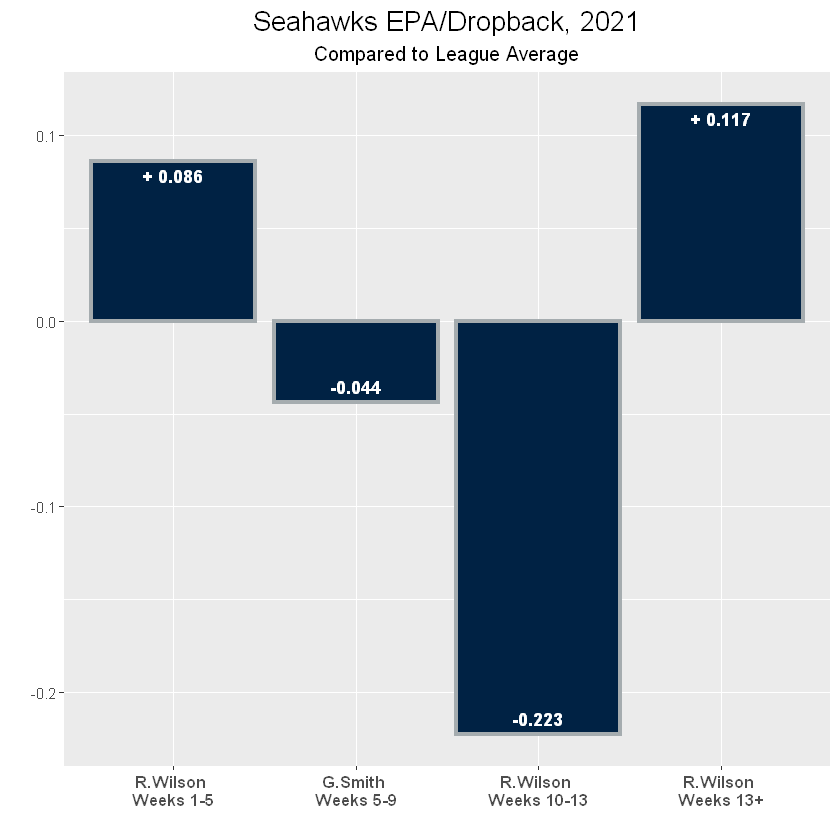

In [27]:
ggplot(final_epa, aes(x = bar_labels, y = epa_dropback)) +
  geom_bar(aes(fill = team_color, color = team_color2), 
           stat = "identity", 
           alpha = 1,
           size = 1.25) +
  scale_color_identity(aesthetics = c("fill", "color")) + 
  geom_text(aes(label = ifelse(epa_dropback < 0, epa_dropback, paste("+", epa_dropback))), 
            vjust = ifelse(final_epa$epa_dropback > 0, 1.5, -0.7), 
            color = "white",
            fontface = "bold") +
  labs(x = "",
       y = "",
       title = "Seahawks EPA/Dropback, 2021",
       subtitle = "Compared to League Average") +
  theme(axis.text.x = element_text(size = 10, face = "bold"),
        plot.title = element_text(size = 16, hjust = 0.5),
        plot.subtitle = element_text(size = 12, hjust = 0.5))

In [28]:
ggsave("russ-effect-bar-graph2.png", width=10, height=6, dpi="retina")